# Library design for MOP mm10

## Gene Scl17a7 with new probe_designer

by Pu Zheng

2020.11.01

## load required packages

In [2]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

# library design specific tools
from ImageAnalysis3.library_tools import LibraryDesigner as ld
from ImageAnalysis3.library_tools import LibraryTools as lt
# biopython imports
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Blast.Applications import NcbiblastnCommandline
from Bio.Blast import NCBIXML

31340


# 1 Extract region sequences

In [3]:
## Some folders
# human genome
reference_folder = r'\\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl'
genome_folder = os.path.join(reference_folder, 'Genome')
# Library directories
pool_folder = r'\\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain'

In [4]:
resolution = 10000
flanking = 100000
# folder for sub-pool
library_folder = os.path.join(pool_folder, f'MOP_marker_genes_{int(resolution/1000)}kb')
if not os.path.exists(library_folder):
    print(f"create library folder: {library_folder}")
    os.makedirs(library_folder)
# folder for fasta sequences
sequence_folder = os.path.join(library_folder, 'sequences')
if not os.path.exists(sequence_folder):
    print(f"create sequence folder: {sequence_folder}")
    os.makedirs(sequence_folder)
# folder to save result probes
report_folder = os.path.join(library_folder, 'reports')
if not os.path.exists(report_folder):
    print(f"create report folder: {report_folder}")
    os.makedirs(report_folder)
    
print(f"-- library_folder: {library_folder}")
print(f"-- sequence_folder: {sequence_folder}")
print(f"-- report_folder: {report_folder}")

-- library_folder: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb
-- sequence_folder: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\sequences
-- report_folder: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\reports


In [5]:
reload(library_tools.sequences)
region_file = os.path.join(library_folder, 'Regions_10kb.txt')
region_dict = library_tools.sequences.read_region_file(region_file)
records = library_tools.sequences.extract_sequence(region_dict, genome_folder, 
                                                   resolution=resolution,
                                                   flanking=flanking,
                                                   save_folder=sequence_folder)

Input region file is: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\Regions_10kb.txt
-- searching among 23 references
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.7.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.2.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.6.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.12.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.16.fa.
-- saving sequences into folder: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\sequences
-- s

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\sequences\Nkx2-1_reg_2.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\sequences\Nkx2-1_reg_3.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\sequences\Nkx2-1_reg_4.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\sequences\Nkx2-1_reg_5.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\sequences\Nkx2-1_reg_6.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\sequences\Nkx2-1_reg_7.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\sequences\Nkx2-1_reg_8.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\sequences\Nkx2-1_reg_9.fasta
-- save to file:

# 2. Design probe targeting sequences by probe_designer


## 2.1 Construct count table with all the 17-mers in the genome

Only do this if you don't have pre-built 17-mer

However you can do almost the same thing for your own library during quality check

This library requires mm10 genome

In [6]:
overwrite_table = False

### construct map for whole genome

In [7]:
reload(library_tools.design)
 
genome_table_file = os.path.join(reference_folder, 'GRCm38_genome_17w.npy')

if not os.path.exists(genome_table_file) or overwrite_table:
    # genome
    _genome_filenames = [os.path.join(genome_folder, _fl) 
         for _fl in os.listdir(genome_folder) 
         if _fl.split(os.extsep)[-1]=='fasta' or _fl.split(os.extsep)[-1]=='fa']
    print(len(_genome_filenames))

    ct = library_tools.design.countTable(word=17,save_file=genome_table_file, 
                       sparse=False)
    ct.verbose=True

    ct.read(_genome_filenames) # read sequences from fasta files

    ct.consume_loaded(num_threads=24) # convert sequences into integers

    ct.complete(verbose=True)

    ct.save()

    # clear RAM if contructed countable 
    del(ct)

### construct map for transcriptome

In [8]:
from tqdm import tqdm
# transcriptome
transcriptome_folder = os.path.join(reference_folder, 'Transcriptome')

transcriptome_table_file = os.path.join(reference_folder, 'GRCm38_transcriptome_17w.npy')

if not os.path.exists(transcriptome_table_file) or overwrite_table:
    # transcriptome
    _transcriptome_filenames = [os.path.join(transcriptome_folder, _fl) 
         for _fl in os.listdir(transcriptome_folder) 
         if _fl.split(os.extsep)[-1]=='fasta' or _fl.split(os.extsep)[-1]=='fa']
    print(len(_transcriptome_filenames))
    
    ct = library_tools.design.countTable(word=17,save_file=transcriptome_table_file, 
                       sparse=False)
    ct.verbose=True

    ct.read(_transcriptome_filenames) # read sequences from fasta files

    ct.consume_loaded(num_threads=24) # convert sequences into integers

    ct.complete(verbose=True)

    ct.save()
    
    # clear RAM if contructed countable 
    del(ct)

### construct map for repeats from RepBase

In [9]:
from tqdm import tqdm
# repeat
repeat_folder = r'\\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\Repbase'

repeat_table_file = os.path.join(reference_folder, 'Repbase_v2603_repeat_17w.npy')

if not os.path.exists(repeat_table_file) or overwrite_table:
    # repeat
    _repeat_filenames = [os.path.join(repeat_folder, _fl) 
         for _fl in os.listdir(repeat_folder) 
         if _fl.split(os.extsep)[-1]=='fasta' or _fl.split(os.extsep)[-1]=='fa']
    print(len(_repeat_filenames))
    
    ct = library_tools.design.countTable(word=17,save_file=repeat_table_file, 
                       sparse=False)
    ct.verbose=True

    ct.read(_repeat_filenames) # read sequences from fasta files

    ct.consume_loaded(num_threads=24) # convert sequences into integers

    ct.complete(verbose=True)

    ct.save()
    
    # clear RAM if contructed countable 
    del(ct)

### construct map for meng's MOP MERFISH library

skipped because not necessary

## 2.2 Design probes

### parameters

In [10]:
resolution = 10000

## required folders
# Library directories
pool_folder = r'\\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain'

library_folder = os.path.join(pool_folder, f'MOP_marker_genes_{int(resolution/1000)}kb')
sequence_folder = os.path.join(library_folder, 'sequences')
report_folder = os.path.join(library_folder, 'reports')

In [11]:
# requires pre_defined genome_folder and library_folder
# Indices
genome_index = os.path.join(reference_folder, 'GRCm38_genome_17w.npy')
transcriptome_index = os.path.join(reference_folder, 'GRCm38_transcriptome_17w.npy') 
repeat_index = os.path.join(reference_folder, 'Repbase_v2603_repeat_17w.npy')
#ref_merfish_index = os.path.join(reference_folder, 'M1_meng_MERFISH_17w.npy') # merfish designed by Meng
# get input files 
input_files = glob.glob(os.path.join(sequence_folder, '*.fasta'))

print(f"{len(input_files)} regions loaded to design probes.")

if not os.path.exists(report_folder):
    os.makedirs(report_folder)
    
# filename to save probe reports
save_file = os.path.join(report_folder, f'merged_probes_{int(resolution/1000)}kb.pbr')
print(save_file)

261 regions loaded to design probes.
\\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\reports\merged_probes_10kb.pbr


### create pb_designer class

In [14]:
reload(library_tools)
reload(library_tools.design)

pb_designer = library_tools.design.pb_reports_class(
    sequence_dic={'file':input_files,
                  'rev_com':True, # design two strands
                  'two_stranded':True},
    map_dic={'genome':{'file':genome_index,'rev_com':False,'two_stranded':True},
             'transcriptome':{'file':transcriptome_index,'rev_com':True,'two_stranded':False},
             'rep_genome':{'file':repeat_index,'rev_com':False,'two_stranded':True},
             'self_sequences':{'file':input_files,'force_list':True,'rev_com':False,'two_stranded':True},
             #'ref_merfish':{'file':ref_merfish_index,'rev_com':False,'two_stranded':True},
             },
        save_file=save_file,
    params_dic={'word_size':17,'pb_len':42,'buffer_len':1,'max_count':2**16-1,
                #'rev_com_score_ratio': 1.0, 
                'check_on_go': False, # whether automatically check probes
                'auto': False, # whether automatically convert reference maps
               },
    check_dic={('genome','self_sequences'): 25,
               'rep_genome': 0,
               'transcriptome': 14,
               #'ref_merfish': 14,
               'gc':[0.25,0.85],'tm': 70,
               }
    )
print(pb_designer)
pb_designer.load_from_file(load_probes_only=True)


Probe designer derived from Bogdan Bintu:
https://github.com/BogdanBintu/ChromatinImaging/blob/master/LibraryDesign/LibraryDesigner.py
by Pu Zheng, 2020.11

Major changes:
    1. allow design of two strands
    2. separate reverse_compliment (rev_com) and from two strands (two_stranded) as 
    two different inputs for map_dic and sequence_dic
    3. replace 'local_genome' with 'self_sequences' to be more explicit, and only 
    exclude the counts for the corresponding self_sequence within each input. 

Key information:
    - number of input_sequence(s): 261
    - save_file location: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\reports\merged_probes_10kb.pbr

- Fail to load from savefile: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\reports\merged_probes_10kb.pbr, file doesn't exist.


False

### calculate probe reports

In [15]:
reload(library_tools)
reload(library_tools.design)
pb_designer.computeOTmaps() # load the tables 
pb_designer.compute_pb_report() # design candidate probes

-- setting attribute: map_genome
--- finish map_genome in 88.690s.
-- setting attribute: map_transcriptome
--- finish map_transcriptome in 91.061s.
-- setting attribute: map_rep_genome
--- finish map_rep_genome in 83.359s.
Time(s): 263.11810874938965
- Designing targeting sequence for 261 regions
-- designing region: 6:126980000-126990000_reg_Ccnd2-1 0, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\sequences\Ccnd2_reg_1.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.118s.
- Save reports into file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\reports\merged_probes_10kb.pbr
in 5.840s.
-- designing region: 6:127070000-127080000_reg_Ccnd2-10 1, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\sequences\Ccnd2_reg_10.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in

- Save reports into file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\reports\merged_probes_10kb.pbr
in 14.016s.
-- designing region: 6:127240000-127250000_reg_Ccnd2-27 19, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\sequences\Ccnd2_reg_27.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.101s.
- Save reports into file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\reports\merged_probes_10kb.pbr
in 17.380s.
-- designing region: 6:127250000-127260000_reg_Ccnd2-28 20, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\sequences\Ccnd2_reg_28.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.119s.
- Save reports into file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\reports\merged_probes_10kb.pbr
in 1

in 22.275s.
-- designing region: 6:127410000-127420000_reg_Ccnd2-44 38, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\sequences\Ccnd2_reg_44.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.123s.
- Save reports into file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\reports\merged_probes_10kb.pbr
in 22.616s.
-- designing region: 6:127420000-127430000_reg_Ccnd2-45 39, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\sequences\Ccnd2_reg_45.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.123s.
- Save reports into file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\reports\merged_probes_10kb.pbr
in 23.144s.
-- designing region: 6:127430000-127440000_reg_Ccnd2-46 40, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain

--- finish map_self_sequences in 0.218s.
- Save reports into file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\reports\merged_probes_10kb.pbr
in 31.933s.
-- designing region: 6:127050000-127060000_reg_Ccnd2-8 58, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\sequences\Ccnd2_reg_8.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.101s.
- Save reports into file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\reports\merged_probes_10kb.pbr
in 33.187s.
-- designing region: 6:127060000-127070000_reg_Ccnd2-9 59, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\sequences\Ccnd2_reg_9.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.093s.
- Save reports into file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10k

- Save reports into file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\reports\merged_probes_10kb.pbr
in 42.779s.
-- designing region: 12:56590000-56600000_reg_Nkx2-1-25 77, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\sequences\Nkx2-1_reg_25.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.111s.
- Save reports into file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\reports\merged_probes_10kb.pbr
in 42.796s.
-- designing region: 12:56600000-56610000_reg_Nkx2-1-26 78, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\sequences\Nkx2-1_reg_26.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.113s.
- Save reports into file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\reports\merged_probes_10kb.pbr
in

- Save reports into file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\reports\merged_probes_10kb.pbr
in 51.685s.
-- designing region: 12:56760000-56770000_reg_Nkx2-1-42 96, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\sequences\Nkx2-1_reg_42.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.152s.
- Save reports into file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\reports\merged_probes_10kb.pbr
in 52.254s.
-- designing region: 12:56770000-56780000_reg_Nkx2-1-43 97, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\sequences\Nkx2-1_reg_43.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.121s.
- Save reports into file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\reports\merged_probes_10kb.pbr
in

- Save reports into file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\reports\merged_probes_10kb.pbr
in 62.101s.
-- designing region: 12:56400000-56410000_reg_Nkx2-1-6 115, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\sequences\Nkx2-1_reg_6.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.160s.
- Save reports into file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\reports\merged_probes_10kb.pbr
in 63.001s.
-- designing region: 12:56940000-56950000_reg_Nkx2-1-60 116, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\sequences\Nkx2-1_reg_60.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.169s.
- Save reports into file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\reports\merged_probes_10kb.pbr
in

- Save reports into file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\reports\merged_probes_10kb.pbr
in 74.892s.
-- designing region: 7:44950000-44960000_reg_Slc17a7-22 134, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\sequences\Slc17a7_reg_22.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.152s.
- Save reports into file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\reports\merged_probes_10kb.pbr
in 75.860s.
-- designing region: 7:44960000-44970000_reg_Slc17a7-23 135, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\sequences\Slc17a7_reg_23.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.112s.
- Save reports into file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\reports\merged_probes_10kb.pb

- Save reports into file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\reports\merged_probes_10kb.pbr
in 84.765s.
-- designing region: 7:44770000-44780000_reg_Slc17a7-4 153, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\sequences\Slc17a7_reg_4.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.172s.
- Save reports into file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\reports\merged_probes_10kb.pbr
in 86.188s.
-- designing region: 7:45130000-45140000_reg_Slc17a7-40 154, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\sequences\Slc17a7_reg_40.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.121s.
- Save reports into file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\reports\merged_probes_10kb.pbr


- Save reports into file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\reports\merged_probes_10kb.pbr
in 97.974s.
-- designing region: 7:45300000-45310000_reg_Slc17a7-57 172, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\sequences\Slc17a7_reg_57.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.132s.
- Save reports into file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\reports\merged_probes_10kb.pbr
in 98.120s.
-- designing region: 7:45310000-45320000_reg_Slc17a7-58 173, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\sequences\Slc17a7_reg_58.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.121s.
- Save reports into file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\reports\merged_probes_10kb.pb

- Save reports into file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\reports\merged_probes_10kb.pbr
in 109.395s.
-- designing region: 2:158520767-158530767_reg_Slc32a1-2 191, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\sequences\Slc32a1_reg_2.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.162s.
- Save reports into file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\reports\merged_probes_10kb.pbr
in 110.291s.
-- designing region: 2:158700767-158710767_reg_Slc32a1-20 192, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\sequences\Slc32a1_reg_20.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.211s.
- Save reports into file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\reports\merged_probes_10k

- Save reports into file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\reports\merged_probes_10kb.pbr
in 121.858s.
-- designing region: 16:23900000-23910000_reg_SST-18 210, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\sequences\SST_reg_18.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.101s.
- Save reports into file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\reports\merged_probes_10kb.pbr
in 123.065s.
-- designing region: 16:23910000-23920000_reg_SST-19 211, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\sequences\SST_reg_19.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.152s.
- Save reports into file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\reports\merged_probes_10kb.pbr
in 123.410

in 134.653s.
-- designing region: 16:24070000-24080000_reg_SST-35 229, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\sequences\SST_reg_35.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.144s.
- Save reports into file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\reports\merged_probes_10kb.pbr
in 135.220s.
-- designing region: 16:24080000-24090000_reg_SST-36 230, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\sequences\SST_reg_36.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.101s.
- Save reports into file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\reports\merged_probes_10kb.pbr
in 135.870s.
-- designing region: 16:24090000-24100000_reg_SST-37 231, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_ma

- Save reports into file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\reports\merged_probes_10kb.pbr
in 154.595s.
-- designing region: 16:24250000-24260000_reg_SST-53 249, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\sequences\SST_reg_53.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.152s.
- Save reports into file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\reports\merged_probes_10kb.pbr
in 155.997s.
-- designing region: 16:24260000-24270000_reg_SST-54 250, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\sequences\SST_reg_54.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.164s.
- Save reports into file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\reports\merged_probes_10kb.pbr
in 155.167

### check probes

In [17]:
pbs, pb_scores = pb_designer.check_probes()

-- check region:0 6:126980000-126990000_reg_Ccnd2-1, 19778 candidate probes
--- 9363 probes passed check_dic, GC and Tm selection.
finish in 0.902s, 135 probes kept.
-- check region:1 6:127070000-127080000_reg_Ccnd2-10, 19732 candidate probes
--- 10376 probes passed check_dic, GC and Tm selection.
finish in 0.848s, 136 probes kept.
-- check region:2 6:127080000-127090000_reg_Ccnd2-11, 19840 candidate probes
--- 8162 probes passed check_dic, GC and Tm selection.
finish in 0.810s, 139 probes kept.
-- check region:3 6:127090000-127100000_reg_Ccnd2-12, 19416 candidate probes
--- 3661 probes passed check_dic, GC and Tm selection.
finish in 0.627s, 62 probes kept.
-- check region:4 6:127100000-127110000_reg_Ccnd2-13, 19432 candidate probes
--- 8445 probes passed check_dic, GC and Tm selection.
finish in 0.803s, 127 probes kept.
-- check region:5 6:127110000-127120000_reg_Ccnd2-14, 19616 candidate probes
--- 7566 probes passed check_dic, GC and Tm selection.
finish in 0.811s, 117 probes kept.

-- check region:49 6:127510000-127520000_reg_Ccnd2-54, 19324 candidate probes
--- 2003 probes passed check_dic, GC and Tm selection.
finish in 0.536s, 34 probes kept.
-- check region:50 6:127520000-127530000_reg_Ccnd2-55, 19804 candidate probes
--- 7027 probes passed check_dic, GC and Tm selection.
finish in 0.799s, 101 probes kept.
-- check region:51 6:127530000-127540000_reg_Ccnd2-56, 19464 candidate probes
--- 7156 probes passed check_dic, GC and Tm selection.
finish in 0.764s, 116 probes kept.
-- check region:52 6:127540000-127550000_reg_Ccnd2-57, 19896 candidate probes
--- 10335 probes passed check_dic, GC and Tm selection.
finish in 0.908s, 134 probes kept.
-- check region:53 6:127550000-127560000_reg_Ccnd2-58, 19900 candidate probes
--- 10117 probes passed check_dic, GC and Tm selection.
finish in 0.922s, 142 probes kept.
-- check region:54 6:127560000-127570000_reg_Ccnd2-59, 19752 candidate probes
--- 11473 probes passed check_dic, GC and Tm selection.
finish in 0.860s, 147 pro

-- check region:98 12:56780000-56790000_reg_Nkx2-1-44, 18880 candidate probes
--- 7987 probes passed check_dic, GC and Tm selection.
finish in 0.771s, 112 probes kept.
-- check region:99 12:56790000-56800000_reg_Nkx2-1-45, 19602 candidate probes
--- 9115 probes passed check_dic, GC and Tm selection.
finish in 0.790s, 133 probes kept.
-- check region:100 12:56800000-56810000_reg_Nkx2-1-46, 19644 candidate probes
--- 10343 probes passed check_dic, GC and Tm selection.
finish in 0.938s, 138 probes kept.
-- check region:101 12:56810000-56820000_reg_Nkx2-1-47, 19774 candidate probes
--- 8727 probes passed check_dic, GC and Tm selection.
finish in 0.869s, 130 probes kept.
-- check region:102 12:56820000-56830000_reg_Nkx2-1-48, 19654 candidate probes
--- 9678 probes passed check_dic, GC and Tm selection.
finish in 0.781s, 132 probes kept.
-- check region:103 12:56830000-56840000_reg_Nkx2-1-49, 19566 candidate probes
--- 7536 probes passed check_dic, GC and Tm selection.
finish in 0.765s, 100 

-- check region:147 7:45070000-45080000_reg_Slc17a7-34, 19788 candidate probes
--- 7047 probes passed check_dic, GC and Tm selection.
finish in 0.788s, 125 probes kept.
-- check region:148 7:45080000-45090000_reg_Slc17a7-35, 19628 candidate probes
--- 6192 probes passed check_dic, GC and Tm selection.
finish in 0.760s, 102 probes kept.
-- check region:149 7:45090000-45100000_reg_Slc17a7-36, 19580 candidate probes
--- 6853 probes passed check_dic, GC and Tm selection.
finish in 0.771s, 106 probes kept.
-- check region:150 7:45100000-45110000_reg_Slc17a7-37, 19530 candidate probes
--- 4934 probes passed check_dic, GC and Tm selection.
finish in 0.657s, 99 probes kept.
-- check region:151 7:45110000-45120000_reg_Slc17a7-38, 19340 candidate probes
--- 5840 probes passed check_dic, GC and Tm selection.
finish in 0.736s, 93 probes kept.
-- check region:152 7:45120000-45130000_reg_Slc17a7-39, 19918 candidate probes
--- 9946 probes passed check_dic, GC and Tm selection.
finish in 0.849s, 145 p

--- 8310 probes passed check_dic, GC and Tm selection.
finish in 0.822s, 123 probes kept.
-- check region:196 2:158550767-158560767_reg_Slc32a1-5, 19594 candidate probes
--- 9716 probes passed check_dic, GC and Tm selection.
finish in 0.818s, 134 probes kept.
-- check region:197 2:158560767-158570767_reg_Slc32a1-6, 19726 candidate probes
--- 9557 probes passed check_dic, GC and Tm selection.
finish in 0.900s, 131 probes kept.
-- check region:198 2:158570767-158580767_reg_Slc32a1-7, 19796 candidate probes
--- 8722 probes passed check_dic, GC and Tm selection.
finish in 0.816s, 123 probes kept.
-- check region:199 2:158580767-158590767_reg_Slc32a1-8, 19858 candidate probes
--- 7190 probes passed check_dic, GC and Tm selection.
finish in 0.766s, 114 probes kept.
-- check region:200 2:158590767-158600767_reg_Slc32a1-9, 19892 candidate probes
--- 7209 probes passed check_dic, GC and Tm selection.
finish in 0.825s, 123 probes kept.
-- check region:201 16:23730000-23740000_reg_SST-1, 17852 ca

-- check region:245 16:23770000-23780000_reg_SST-5, 19862 candidate probes
--- 7433 probes passed check_dic, GC and Tm selection.
finish in 0.757s, 114 probes kept.
-- check region:246 16:24220000-24230000_reg_SST-50, 19918 candidate probes
--- 8319 probes passed check_dic, GC and Tm selection.
finish in 0.825s, 135 probes kept.
-- check region:247 16:24230000-24240000_reg_SST-51, 19890 candidate probes
--- 10895 probes passed check_dic, GC and Tm selection.
finish in 0.919s, 147 probes kept.
-- check region:248 16:24240000-24250000_reg_SST-52, 19918 candidate probes
--- 7795 probes passed check_dic, GC and Tm selection.
finish in 0.789s, 116 probes kept.
-- check region:249 16:24250000-24260000_reg_SST-53, 19860 candidate probes
--- 8485 probes passed check_dic, GC and Tm selection.
finish in 0.748s, 124 probes kept.
-- check region:250 16:24260000-24270000_reg_SST-54, 19918 candidate probes
--- 6066 probes passed check_dic, GC and Tm selection.
finish in 0.728s, 101 probes kept.
-- c

### save probes

In [20]:
list(pb_designer.kept_probes.values())[0]

{'name': '6:126980000-126990000_reg_Ccnd2-1_pb_31',
 'reg_index': 0,
 'reg_name': '6:126980000-126990000_reg_Ccnd2-1',
 'pb_index': 31,
 'strand': '+',
 'gc': 0.42857142857142855,
 'tm': 77.04397805909713,
 'map_genome': 35,
 'map_transcriptome': 0,
 'map_rep_genome': 0,
 'map_self_sequences': 26}

In [19]:
overwrite_savefile = True 
if not os.path.exists(pb_designer.save_file) or overwrite_savefile:
    #pb_designer.plots()
    #pb_designer.save_csv()
    pb_designer.save_to_file()
print(f"-- number of probes kept: {len(pb_designer.kept_probes)}")

- Save reports into file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\reports\merged_probes_10kb.pbr
-- number of probes kept: 32437


## 2.3 summarize into a pb_dict

In [21]:
verbose=True
cand_prob_nums = []
pb_dic = {}
# Parse segemented list
_save_file = os.path.join(report_folder, f'merged_probes_{int(resolution/1000)}kb.pbr')
_pbde = library_tools.design.pb_reports_class()
_pbde.load_from_file(_save_file)

reg_inds = np.sort(np.unique([_v['reg_index'] for _s, _v in _pbde.kept_probes.items()]))
for _rid in reg_inds:
    _sel_pbs = {_s:_v for _s, _v in _pbde.kept_probes.items() if _v['reg_index']==_rid}

    if len(_sel_pbs) > 0:
        _region_gid = list(_sel_pbs.values())[0]['reg_name'].split('_')[-1]
        cand_prob_nums.append(len(_sel_pbs))
        if verbose:
            print(f"-- appending region:{_region_gid} with {len(_sel_pbs)} probes")
        _splitted_pbde = ld.pb_reports_class()
        _splitted_pbde.kept_probes = _sel_pbs
        pb_dic[_region_gid] = _splitted_pbde

- Loading from savefile: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\reports\merged_probes_10kb.pbr.
cand_probes
kept_probes
32437
sequence_dic
map_dic
params_dic
check_dic
save_file
-- appending region:Ccnd2-1 with 135 probes
-- appending region:Ccnd2-10 with 136 probes
-- appending region:Ccnd2-11 with 139 probes
-- appending region:Ccnd2-12 with 62 probes
-- appending region:Ccnd2-13 with 127 probes
-- appending region:Ccnd2-14 with 117 probes
-- appending region:Ccnd2-15 with 125 probes
-- appending region:Ccnd2-16 with 136 probes
-- appending region:Ccnd2-17 with 147 probes
-- appending region:Ccnd2-18 with 146 probes
-- appending region:Ccnd2-19 with 143 probes
-- appending region:Ccnd2-2 with 99 probes
-- appending region:Ccnd2-20 with 142 probes
-- appending region:Ccnd2-21 with 139 probes
-- appending region:Ccnd2-22 with 126 probes
-- appending region:Ccnd2-23 with 138 probes
-- appending region:Ccnd2-24 with 136 probes
-- appending region:Ccn

-- appending region:Slc32a1-12 with 129 probes
-- appending region:Slc32a1-13 with 144 probes
-- appending region:Slc32a1-14 with 121 probes
-- appending region:Slc32a1-15 with 127 probes
-- appending region:Slc32a1-16 with 114 probes
-- appending region:Slc32a1-17 with 141 probes
-- appending region:Slc32a1-18 with 127 probes
-- appending region:Slc32a1-19 with 136 probes
-- appending region:Slc32a1-2 with 138 probes
-- appending region:Slc32a1-20 with 135 probes
-- appending region:Slc32a1-21 with 144 probes
-- appending region:Slc32a1-3 with 129 probes
-- appending region:Slc32a1-4 with 123 probes
-- appending region:Slc32a1-5 with 134 probes
-- appending region:Slc32a1-6 with 131 probes
-- appending region:Slc32a1-7 with 123 probes
-- appending region:Slc32a1-8 with 114 probes
-- appending region:Slc32a1-9 with 123 probes
-- appending region:SST-1 with 105 probes
-- appending region:SST-10 with 141 probes
-- appending region:SST-11 with 145 probes
-- appending region:SST-12 with 14

In [22]:
# filter by genome counts
reload(library_tools.quality_check)

num_probes_kept = 160 # max num of probes kept for each region
filtered_pb_dic = library_tools.quality_check.Screen_probe_by_hit(library_folder, pb_dic, num_probes_kept,
                                                                  hit_type='genome')

## filter by minimum number of probes in each region
min_num_probes = 25 
removed_regions = []
for _rid, _pb_class in filtered_pb_dic.items():
    if len(_pb_class.kept_probes) < min_num_probes:
        print(f"region: {_rid} removed with {len(_pb_class.kept_probes)} probes")
        removed_regions.append(_rid)
for _rid in removed_regions:
    del(filtered_pb_dic[_rid])

- Screen probes by genome counts.
-- filtering region:Ccnd2-1, directly append 135 probes
-- filtering region:Ccnd2-10, directly append 136 probes
-- filtering region:Ccnd2-11, directly append 139 probes
-- filtering region:Ccnd2-12, directly append 62 probes
-- filtering region:Ccnd2-13, directly append 127 probes
-- filtering region:Ccnd2-14, directly append 117 probes
-- filtering region:Ccnd2-15, directly append 125 probes
-- filtering region:Ccnd2-16, directly append 136 probes
-- filtering region:Ccnd2-17, directly append 147 probes
-- filtering region:Ccnd2-18, directly append 146 probes
-- filtering region:Ccnd2-19, directly append 143 probes
-- filtering region:Ccnd2-2, directly append 99 probes
-- filtering region:Ccnd2-20, directly append 142 probes
-- filtering region:Ccnd2-21, directly append 139 probes
-- filtering region:Ccnd2-22, directly append 126 probes
-- filtering region:Ccnd2-23, directly append 138 probes
-- filtering region:Ccnd2-24, directly append 136 probes
-

## 2.4 check candidate probe number per region

<IPython.core.display.Javascript object>


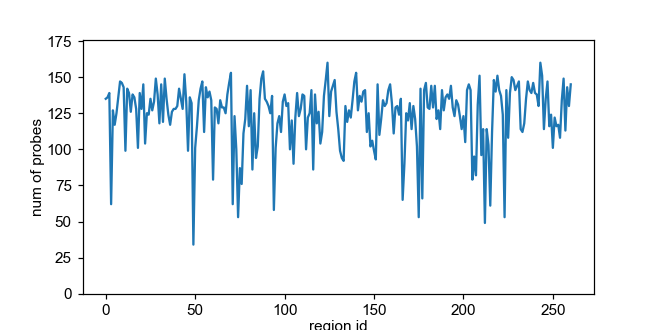

In [23]:
pb_num_dict = {_k:len(_v.kept_probes) for _k,_v in filtered_pb_dic.items()}

pb_nums = np.array(list(pb_num_dict.values()))
plt.figure(figsize=(6,3), dpi=100)
plt.plot(pb_nums)
#plt.plot(np.ones(len(pb_nums))*20)
plt.ylabel(f"num of probes", labelpad=1)
plt.xlabel(f"region id", labelpad=1)
plt.ylim([0, num_probes_kept*1.1])
plt.show()

# 3. Load and asssemble probes

## 3.1 design readout mapping dict (region_to_readout)

idea for this library:

1. each gene has bit 1-60 as common readouts to allow parallel sequential imaging

2. each gene has unique readouts (the same encoding probe has one site for part 1, one site for part 2)

3. eventually 5% of all probes have their probes converted into gene-specific readouts

In [36]:
filtered_pb_dic

{'Ccnd2-1': <ImageAnalysis3.library_tools.LibraryDesigner.pb_reports_class at 0x250ff88fbc8>,
 'Ccnd2-10': <ImageAnalysis3.library_tools.LibraryDesigner.pb_reports_class at 0x250ff88fd88>,
 'Ccnd2-11': <ImageAnalysis3.library_tools.LibraryDesigner.pb_reports_class at 0x250ff88fec8>,
 'Ccnd2-12': <ImageAnalysis3.library_tools.LibraryDesigner.pb_reports_class at 0x251aa96d3c8>,
 'Ccnd2-13': <ImageAnalysis3.library_tools.LibraryDesigner.pb_reports_class at 0x251aa96e4c8>,
 'Ccnd2-14': <ImageAnalysis3.library_tools.LibraryDesigner.pb_reports_class at 0x250ff8cf448>,
 'Ccnd2-15': <ImageAnalysis3.library_tools.LibraryDesigner.pb_reports_class at 0x250ff8cf608>,
 'Ccnd2-16': <ImageAnalysis3.library_tools.LibraryDesigner.pb_reports_class at 0x251aeb7bd88>,
 'Ccnd2-17': <ImageAnalysis3.library_tools.LibraryDesigner.pb_reports_class at 0x250ff8cfb08>,
 'Ccnd2-18': <ImageAnalysis3.library_tools.LibraryDesigner.pb_reports_class at 0x250ff8cfc88>,
 'Ccnd2-19': <ImageAnalysis3.library_tools.LibraryD

In [47]:
# split regions based on genes
gene_2_region_2_pbs_dict = {}
for _reg, _pbs in filtered_pb_dic.items():
    
    _ind = int(_reg.split('-')[-1])
    _gene = _reg[:-len(str(_ind))-1]
    if _gene not in gene_2_region_2_pbs_dict:
        gene_2_region_2_pbs_dict[_gene] = {}
    gene_2_region_2_pbs_dict[_gene][_ind] = _pbs
max_gene_length = max([len(_dict) for _dict in gene_2_region_2_pbs_dict.values()])

In [62]:
# generate region_2_readout_dict
region_2_readout_dict = {}
num_readout_per_probe = 2

total_readout_usage = max_gene_length

for _gene, _region_2_pbs in gene_2_region_2_pbs_dict.items():
    for _i, _ind in enumerate(sorted(_region_2_pbs)):
        # for reach region, generate readout usage
        #print(_gene, _ind, total_readout_usage)
        _readout_usage = [f'u{_i}']
        for _j in range(num_readout_per_probe-1):
            _readout_usage += [f'u{total_readout_usage}']
            total_readout_usage += 1
        # append
        region_2_readout_dict[f"{_gene}-{_ind}"] = _readout_usage

print(f"Number of used readouts: {total_readout_usage}")

Number of used readouts: 321


## 3.2 loading components

### primers
pick primer set 2, 9 for 5kb (consistent with CTP-06)

In [23]:
num_readout_per_probe = 2
total_readout_usage = 0
region_2_readout_dict = {}
for _i, (_k,_v) in enumerate(sorted(filtered_pb_dic.items())):
    region_2_readout_dict[_k] = []
    for _j in range(num_readout_per_probe):
        region_2_readout_dict[_k].append(f"u{int(_i+_j*len(filtered_pb_dic))}")
        total_readout_usage += 1
print(total_readout_usage)

120


In [54]:
primer_folder = r'\\10.245.74.212\Chromatin_NAS_2\Libraries\Primers'
primers = library_tools.assemble.load_primers([2,9], _primer_folder=primer_folder)

- Picked primer: ID: W1A03_primer_2
Name: W1A03_primer_2
Description: W1A03_primer_2
Number of features: 0
Seq('CCCGCAATGGCTGACAACCG')
- Picked primer: ID: W1A10_primer_9
Name: W1A10_primer_9
Description: W1A10_primer_9
Number of features: 0
Seq('TAATACGACTCACTATAGGGATTGCCGCATGGTTTCCG')


In [55]:
reload(library_tools.assemble)
readout_folder = r'\\10.245.74.212\Chromatin_NAS_2\Libraries\Readouts'
readout_start = 0
num_color = 2
readouts = library_tools.assemble.load_readouts(total_readout_usage, 
                                               _type='designed_readouts', 
                                               _readout_folder=readout_folder, 
                                               _num_colors=2, # 750, 647
                                               )

readout_dict = {'u': readouts}

In [57]:
readout_dict['u']

[SeqRecord(seq=Seq('ACAAATCCGACCAGATCGGACGATCATGGG'), id='Stv_3', name='Stv_3', description='Stv_3 old_barcode', dbxrefs=[]),
 SeqRecord(seq=Seq('AGACGACGCACGTTCGTACCGCGTACTTCG'), id='Stv_32', name='Stv_32', description='Stv_32 old_barcode', dbxrefs=[]),
 SeqRecord(seq=Seq('CAAGTATGCAGCGCGATTGACCGTCTCGTT'), id='Stv_4', name='Stv_4', description='Stv_4 old_barcode', dbxrefs=[]),
 SeqRecord(seq=Seq('TTTGCTCGCAAGTGCGCACGAGTTGAACTG'), id='Stv_33', name='Stv_33', description='Stv_33 old_barcode', dbxrefs=[]),
 SeqRecord(seq=Seq('AAGTCGTACGCCGATGCGCAGCAATTCACT'), id='Stv_5', name='Stv_5', description='Stv_5 old_barcode', dbxrefs=[]),
 SeqRecord(seq=Seq('AGTTTCCATACGCGGCGTGAATATCGCGGC'), id='Stv_35', name='Stv_35', description='Stv_35 old_barcode', dbxrefs=[]),
 SeqRecord(seq=Seq('CGAAACATCGGCCACGGTCCCGTTGAACTT'), id='Stv_6', name='Stv_6', description='Stv_6 old_barcode', dbxrefs=[]),
 SeqRecord(seq=Seq('GCTACAGCGTTACGGGCCCAGACGTTTCAT'), id='Stv_36', name='Stv_36', description='Stv_36 old_bar

## 3.3 assemble probes

In [199]:
reload(library_tools.assemble)
from ImageAnalysis3.library_tools.assemble import Assemble_probes

cand_probes, readout_summary = Assemble_probes(library_folder, filtered_pb_dic, 
                                               region_2_readout_dict, readout_dict, primers, 
                                               primer_len=19,
                                               rc_targets=False, overwrite=True)

- Assemble probes by given target sequences, readouts and primers.
-- included readout types: ['u']
--- assemblying 135 probes in region: Ccnd2-1
--- assemblying 136 probes in region: Ccnd2-10
--- assemblying 139 probes in region: Ccnd2-11
--- assemblying 62 probes in region: Ccnd2-12
--- assemblying 127 probes in region: Ccnd2-13
--- assemblying 117 probes in region: Ccnd2-14
--- assemblying 125 probes in region: Ccnd2-15
--- assemblying 136 probes in region: Ccnd2-16
--- assemblying 147 probes in region: Ccnd2-17
--- assemblying 146 probes in region: Ccnd2-18
--- assemblying 143 probes in region: Ccnd2-19
--- assemblying 99 probes in region: Ccnd2-2
--- assemblying 142 probes in region: Ccnd2-20
--- assemblying 139 probes in region: Ccnd2-21
--- assemblying 126 probes in region: Ccnd2-22
--- assemblying 138 probes in region: Ccnd2-23
--- assemblying 136 probes in region: Ccnd2-24
--- assemblying 128 probes in region: Ccnd2-25
--- assemblying 101 probes in region: Ccnd2-26
--- assembl

--- assemblying 144 probes in region: Slc32a1-11
--- assemblying 129 probes in region: Slc32a1-12
--- assemblying 144 probes in region: Slc32a1-13
--- assemblying 121 probes in region: Slc32a1-14
--- assemblying 127 probes in region: Slc32a1-15
--- assemblying 114 probes in region: Slc32a1-16
--- assemblying 141 probes in region: Slc32a1-17
--- assemblying 127 probes in region: Slc32a1-18
--- assemblying 136 probes in region: Slc32a1-19
--- assemblying 138 probes in region: Slc32a1-2
--- assemblying 135 probes in region: Slc32a1-20
--- assemblying 144 probes in region: Slc32a1-21
--- assemblying 129 probes in region: Slc32a1-3
--- assemblying 123 probes in region: Slc32a1-4
--- assemblying 134 probes in region: Slc32a1-5
--- assemblying 131 probes in region: Slc32a1-6
--- assemblying 123 probes in region: Slc32a1-7
--- assemblying 114 probes in region: Slc32a1-8
--- assemblying 123 probes in region: Slc32a1-9
--- assemblying 105 probes in region: SST-1
--- assemblying 141 probes in reg

### specific to this library: swap out ~5% of the probes from this library to convert into gene_specific readouts

In [200]:
pb_id = 10
print(cand_probes[pb_id].id)
print(cand_probes[pb_id].seq)

6:126980000-126990000_gene_Ccnd2-1_pb_10_pos_943_strand_+_readouts_[Stv_3_u,NDB_16_u]
CCGCAATGGCTGACAACCGCCCATGATCGTCCGATCTGGCATAGACAGGTGTGACCCACGAGGAGAGCATATGGACAGATCGCGCATCGCGGCTAATAGAGCGGAAACCATGCGGCAATC


In [206]:
gene_2_readout = {}
gene_readouts = library_tools.assemble.load_readouts(len(gene_2_region_2_pbs_dict), 
                                                     _type='designed_readouts', 
                                                     _readout_folder=readout_folder, 
                                                     _num_colors=1, _start_channel=2,# 561
                                                     )
_gene_readout_usage = 0
for _reg, _pbs in filtered_pb_dic.items():
    _ind = int(_reg.split('-')[-1])
    _gene = _reg[:-len(str(_ind))-1]
    if _gene not in gene_2_readout:
        gene_2_readout[_gene] = gene_readouts[_gene_readout_usage]
        _gene_readout_usage += 1
print([[_gene, _r.id] for _gene, _r in gene_2_readout.items()])

[['Ccnd2', 'Stv_91'], ['Nkx2-1', 'Stv_92'], ['Slc17a7', 'Stv_94'], ['Slc32a1', 'Stv_95'], ['SST', 'Stv_99']]


In [239]:
reload(library_tools.assemble)
reload(library_tools.quality_check)
swap_ratio = 0.05
new_cand_probes = library_tools.assemble.replace_gene_specifc_readouts(cand_probes, gene_2_readout, swap_ratio,
                                                                       region_pb_lower_limit=80,
                                                                       primer_len=19)
print(len(new_cand_probes))

- replace 0.05 of Ccnd2 probes with readout: Stv_91
-- 7 probes in gene:Ccnd2, reg:1
-- 5 probes in gene:Ccnd2, reg:2
-- 6 probes in gene:Ccnd2, reg:3
-- 8 probes in gene:Ccnd2, reg:4
-- 8 probes in gene:Ccnd2, reg:5
-- 6 probes in gene:Ccnd2, reg:6
-- 7 probes in gene:Ccnd2, reg:7
-- 7 probes in gene:Ccnd2, reg:8
-- 7 probes in gene:Ccnd2, reg:9
-- 7 probes in gene:Ccnd2, reg:10
-- 7 probes in gene:Ccnd2, reg:11
-- skip gene:Ccnd2, reg:12 with 62 probes
-- 7 probes in gene:Ccnd2, reg:13
-- 6 probes in gene:Ccnd2, reg:14
-- 7 probes in gene:Ccnd2, reg:15
-- 7 probes in gene:Ccnd2, reg:16
-- 7 probes in gene:Ccnd2, reg:17
-- 8 probes in gene:Ccnd2, reg:18
-- 8 probes in gene:Ccnd2, reg:19
-- 8 probes in gene:Ccnd2, reg:20
-- 7 probes in gene:Ccnd2, reg:21
-- 6 probes in gene:Ccnd2, reg:22
-- 6 probes in gene:Ccnd2, reg:23
-- 7 probes in gene:Ccnd2, reg:24
-- 7 probes in gene:Ccnd2, reg:25
-- 6 probes in gene:Ccnd2, reg:26
-- 7 probes in gene:Ccnd2, reg:27
-- 7 probes in gene:Ccnd2, reg:

-- 8 probes in gene:SST, reg:33
-- 8 probes in gene:SST, reg:34
-- 8 probes in gene:SST, reg:35
-- 8 probes in gene:SST, reg:36
-- 7 probes in gene:SST, reg:37
-- 6 probes in gene:SST, reg:38
-- 6 probes in gene:SST, reg:39
-- 7 probes in gene:SST, reg:40
-- 7 probes in gene:SST, reg:41
-- 8 probes in gene:SST, reg:42
-- 7 probes in gene:SST, reg:43
-- 8 probes in gene:SST, reg:44
-- 7 probes in gene:SST, reg:45
-- 6 probes in gene:SST, reg:46
-- 7 probes in gene:SST, reg:47
-- 8 probes in gene:SST, reg:48
-- 8 probes in gene:SST, reg:49
-- 7 probes in gene:SST, reg:50
-- 7 probes in gene:SST, reg:51
-- 6 probes in gene:SST, reg:52
-- 7 probes in gene:SST, reg:53
-- 6 probes in gene:SST, reg:54
-- 7 probes in gene:SST, reg:55
-- 6 probes in gene:SST, reg:56
-- 6 probes in gene:SST, reg:57
-- 6 probes in gene:SST, reg:58
-- 7 probes in gene:SST, reg:59
-- 6 probes in gene:SST, reg:60
- 338 probes for SST replaced.
32432


In [240]:
# save replaced 
with open(os.path.join(library_folder, 'gene_replaced_candidate_probes.fasta'), 'w') as _output_handle:
    SeqIO.write(new_cand_probes, _output_handle, "fasta")

# 4.Check quality

## 4.1 Load probes

In [241]:
# folder for this library
# candidate full-length probe filename
#candidate_full_name = 'candidate_probes.fasta' # old version
candidate_full_name = 'gene_replaced_candidate_probes.fasta' # gene readout replaced version
# load full probes
full_records = []
with open(os.path.join(library_folder, candidate_full_name), 'r') as handle:
    for record in SeqIO.parse(handle, "fasta"):
        full_records.append(record)

print(f"Total probe loaded: {len(full_records)}")

Total probe loaded: 32432


In [242]:
num_readout_per_probe = 2
primer_len=19
min_num_probes = 25 

In [243]:
import ImageAnalysis3.library_tools.quality_check as check
reload(check)
primer_check = check._check_primer_usage(full_records, primers[0], primers[1], primer_len=primer_len)


-- Checking primer usage, total probes: 32432


In [244]:
reg_size_dic, len_check = check._check_region_size(full_records, 
                                                   min_size=min_num_probes)

gene: Ccnd2-1 -> 135
gene: Ccnd2-2 -> 99
gene: Ccnd2-3 -> 104
gene: Ccnd2-4 -> 149
gene: Ccnd2-5 -> 152
gene: Ccnd2-6 -> 112
gene: Ccnd2-7 -> 136
gene: Ccnd2-8 -> 140
gene: Ccnd2-9 -> 134
gene: Ccnd2-10 -> 136
gene: Ccnd2-11 -> 139
gene: Ccnd2-12 -> 62
gene: Ccnd2-13 -> 127
gene: Ccnd2-14 -> 117
gene: Ccnd2-15 -> 125
gene: Ccnd2-16 -> 136
gene: Ccnd2-17 -> 147
gene: Ccnd2-18 -> 146
gene: Ccnd2-19 -> 143
gene: Ccnd2-20 -> 142
gene: Ccnd2-21 -> 139
gene: Ccnd2-22 -> 126
gene: Ccnd2-23 -> 138
gene: Ccnd2-24 -> 136
gene: Ccnd2-25 -> 128
gene: Ccnd2-26 -> 101
gene: Ccnd2-27 -> 139
gene: Ccnd2-28 -> 128
gene: Ccnd2-29 -> 145
gene: Ccnd2-30 -> 125
gene: Ccnd2-31 -> 124
gene: Ccnd2-32 -> 135
gene: Ccnd2-33 -> 127
gene: Ccnd2-34 -> 133
gene: Ccnd2-35 -> 149
gene: Ccnd2-36 -> 138
gene: Ccnd2-37 -> 118
gene: Ccnd2-38 -> 145
gene: Ccnd2-39 -> 119
gene: Ccnd2-40 -> 135
gene: Ccnd2-41 -> 124
gene: Ccnd2-42 -> 117
gene: Ccnd2-43 -> 126
gene: Ccnd2-44 -> 128
gene: Ccnd2-45 -> 128
gene: Ccnd2-46 -> 130

In [245]:
# update readout_dict
updated_readout_dict = {_k:_v for _k,_v in readout_dict.items()}
updated_readout_dict['u'].extend(gene_readouts)

reg_readout_dic, reg2readout_check = check._check_region_to_readouts(full_records, updated_readout_dict, 
                                                                     total_readout_num=num_readout_per_probe+1)

Ccnd2-1 -> ['Stv_3', 'Stv_91', 'NDB_16']
Ccnd2-2 -> ['Stv_32', 'Stv_91', 'NDB_17']
Ccnd2-3 -> ['Stv_4', 'Stv_91', 'NDB_19']
Ccnd2-4 -> ['Stv_33', 'Stv_91', 'NDB_20']
Ccnd2-5 -> ['Stv_5', 'Stv_91', 'NDB_22']
Ccnd2-6 -> ['Stv_35', 'Stv_91', 'NDB_23']
Ccnd2-7 -> ['Stv_6', 'Stv_91', 'NDB_25']
Ccnd2-8 -> ['Stv_36', 'Stv_91', 'NDB_26']
Ccnd2-9 -> ['Stv_7', 'Stv_91', 'NDB_28']
Ccnd2-10 -> ['Stv_37', 'Stv_91', 'NDB_29']
Ccnd2-11 -> ['Stv_8', 'Stv_91', 'NDB_31']
-- Error in barcode number for region: Ccnd2-12
Ccnd2-12 -> ['Stv_39', 'NDB_32']
Ccnd2-13 -> ['Stv_9', 'Stv_91', 'NDB_34']
Ccnd2-14 -> ['Stv_40', 'Stv_91', 'NDB_35']
Ccnd2-15 -> ['Stv_10', 'Stv_91', 'NDB_37']
Ccnd2-16 -> ['Stv_42', 'Stv_91', 'NDB_38']
Ccnd2-17 -> ['Stv_11', 'Stv_91', 'NDB_40']
Ccnd2-18 -> ['Stv_44', 'Stv_91', 'NDB_41']
Ccnd2-19 -> ['Stv_12', 'Stv_91', 'NDB_43']
Ccnd2-20 -> ['Stv_45', 'Stv_91', 'NDB_44']
Ccnd2-21 -> ['Stv_13', 'Stv_91', 'NDB_46']
Ccnd2-22 -> ['Stv_46', 'Stv_91', 'NDB_47']
Ccnd2-23 -> ['Stv_14', 'Stv_91',

In [247]:
readout_reg_dic, readout2reg_check = check._check_readout_to_region(reg_readout_dic, full_records, 
                                                                    updated_readout_dict, primer_len=primer_len, 
                                                                    probe_readout_num=num_readout_per_probe)

-- extracting probes from >region:Ccnd2-1, region:Ccnd2-2, region:Ccnd2-3, region:Ccnd2-4, region:Ccnd2-5, region:Ccnd2-6, region:Ccnd2-7, region:Ccnd2-8, region:Ccnd2-9, region:Ccnd2-10, region:Ccnd2-11, region:Ccnd2-12, region:Ccnd2-13, region:Ccnd2-14, region:Ccnd2-15, region:Ccnd2-16, region:Ccnd2-17, region:Ccnd2-18, region:Ccnd2-19, region:Ccnd2-20, region:Ccnd2-21, region:Ccnd2-22, region:Ccnd2-23, region:Ccnd2-24, region:Ccnd2-25, region:Ccnd2-26, region:Ccnd2-27, region:Ccnd2-28, region:Ccnd2-29, region:Ccnd2-30, region:Ccnd2-31, region:Ccnd2-32, region:Ccnd2-33, region:Ccnd2-34, region:Ccnd2-35, region:Ccnd2-36, region:Ccnd2-37, region:Ccnd2-38, region:Ccnd2-39, region:Ccnd2-40, region:Ccnd2-41, region:Ccnd2-42, region:Ccnd2-43, region:Ccnd2-44, region:Ccnd2-45, region:Ccnd2-46, region:Ccnd2-47, region:Ccnd2-48, region:Ccnd2-49, region:Ccnd2-50, region:Ccnd2-51, region:Ccnd2-52, region:Ccnd2-53, region:Ccnd2-54, region:Ccnd2-55, region:Ccnd2-56, region:Ccnd2-57, region:Ccnd2-

In [249]:
print(primer_check, len_check, reg2readout_check, readout2reg_check)

True True False True


In [254]:
# construct internal map
int_map = check._construct_internal_map(full_records, library_folder) 
# internal check probes
readout_count_dic, readout_count_check = check._check_readout_in_probes(readout_reg_dic, reg_size_dic, int_map, readout_dict)
print(readout_count_check)

-- saving internal 17-mer map to file:\\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\probe_table_17.npz
True


In [257]:
# check between probes
kept_records, removed_count = check._check_between_probes(full_records, int_map, primer_len=primer_len)

-- total probes removed by internal screening: 0


In [258]:
# save kept records
with open(os.path.join(library_folder, 'filtered_full_probes.fasta'), 'w') as output_handle:
    SeqIO.write(kept_records, output_handle, "fasta")

## 4.2 BLAST screening of probes

create the local blast database by:
```bash
makeblastdb -in C:\Users\puzheng\Documents\Tools\lowercase_masked\Mus_musculus.GRCm38.dna_sm.merged.fa -dbtype nucl -parse_seqids -out GRCm38_ensembl -title "Mouse chromosomes soft masked" -blastdb_version 4![image.png](attachment:image.png)
```

The outputs are:
```bash
Building a new DB, current time: 03/30/2021 21:49:18
New DB name:   C:\Users\puzheng\Documents\Tools\GRCm38_ensembl
New DB title:  Mouse chromosomes soft masked
Sequence type: Nucleotide
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 66 sequences in 42.2668 seconds.
```

In [259]:
blast_database = os.path.join(reference_folder, 'blast_database', 'GRCm38_ensembl')

check.Blast_probes(kept_records, library_folder, num_threads=20, 
                   blast_db=blast_database)

- Blast probe against \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\blast_database\GRCm38_ensembl
-- number of probes loaded: 32432
--- processing region: Ccnd2-1 with 135 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\blast\probe_gene_Ccnd2-1.fasta
-- *blasting region: Ccnd2-1
--- total time for blast Ccnd2-1: 9.974999189376831
--- processing region: Ccnd2-10 with 136 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\blast\probe_gene_Ccnd2-10.fasta
-- *blasting region: Ccnd2-10
--- total time for blast Ccnd2-10: 9.420455694198608
--- processing region: Ccnd2-11 with 139 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\blast\probe_gene_Ccnd2-11.fasta
-- *blasting region: Ccnd2-11
--- total time for blast Ccnd2-11: 9.010926723480225
--- processing region: Ccnd2-12 with 62 probes
--- *writing file: \\10

--- total time for blast Ccnd2-38: 8.778576135635376
--- processing region: Ccnd2-39 with 119 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\blast\probe_gene_Ccnd2-39.fasta
-- *blasting region: Ccnd2-39
--- total time for blast Ccnd2-39: 9.420511245727539
--- processing region: Ccnd2-4 with 149 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\blast\probe_gene_Ccnd2-4.fasta
-- *blasting region: Ccnd2-4
--- total time for blast Ccnd2-4: 8.989366292953491
--- processing region: Ccnd2-40 with 135 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\blast\probe_gene_Ccnd2-40.fasta
-- *blasting region: Ccnd2-40
--- total time for blast Ccnd2-40: 9.973755836486816
--- processing region: Ccnd2-41 with 124 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\blast\probe_gene_Ccnd2-41.fast

--- total time for blast Nkx2-1-12: 9.640823602676392
--- processing region: Nkx2-1-13 with 134 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\blast\probe_gene_Nkx2-1-13.fasta
-- *blasting region: Nkx2-1-13
--- total time for blast Nkx2-1-13: 9.032560586929321
--- processing region: Nkx2-1-14 with 129 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\blast\probe_gene_Nkx2-1-14.fasta
-- *blasting region: Nkx2-1-14
--- total time for blast Nkx2-1-14: 7.930529356002808
--- processing region: Nkx2-1-15 with 129 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\blast\probe_gene_Nkx2-1-15.fasta
-- *blasting region: Nkx2-1-15
--- total time for blast Nkx2-1-15: 8.215431213378906
--- processing region: Nkx2-1-16 with 125 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\blast\probe_

--- total time for blast Nkx2-1-41: 7.263504505157471
--- processing region: Nkx2-1-42 with 118 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\blast\probe_gene_Nkx2-1-42.fasta
-- *blasting region: Nkx2-1-42
--- total time for blast Nkx2-1-42: 12.518338918685913
--- processing region: Nkx2-1-43 with 123 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\blast\probe_gene_Nkx2-1-43.fasta
-- *blasting region: Nkx2-1-43
--- total time for blast Nkx2-1-43: 8.83612060546875
--- processing region: Nkx2-1-44 with 112 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\blast\probe_gene_Nkx2-1-44.fasta
-- *blasting region: Nkx2-1-44
--- total time for blast Nkx2-1-44: 9.259239912033081
--- processing region: Nkx2-1-45 with 133 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\blast\probe_

--- total time for blast SST-16: 8.865233898162842
--- processing region: SST-17 with 151 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\blast\probe_gene_SST-17.fasta
-- *blasting region: SST-17
--- total time for blast SST-17: 10.462542533874512
--- processing region: SST-18 with 96 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\blast\probe_gene_SST-18.fasta
-- *blasting region: SST-18
--- total time for blast SST-18: 17.58848810195923
--- processing region: SST-19 with 114 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\blast\probe_gene_SST-19.fasta
-- *blasting region: SST-19
--- total time for blast SST-19: 10.00341510772705
--- processing region: SST-2 with 49 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\blast\probe_gene_SST-2.fasta
-- *blasting region: SST-2


--- total time for blast SST-46: 10.263249158859253
--- processing region: SST-47 with 130 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\blast\probe_gene_SST-47.fasta
-- *blasting region: SST-47
--- total time for blast SST-47: 9.985980033874512
--- processing region: SST-48 with 160 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\blast\probe_gene_SST-48.fasta
-- *blasting region: SST-48
--- total time for blast SST-48: 12.421011686325073
--- processing region: SST-49 with 151 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\blast\probe_gene_SST-49.fasta
-- *blasting region: SST-49
--- total time for blast SST-49: 8.286566019058228
--- processing region: SST-5 with 114 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\blast\probe_gene_SST-5.fasta
-- *blasting region: SST

--- total time for blast Slc17a7-20: 8.244128704071045
--- processing region: Slc17a7-21 with 92 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\blast\probe_gene_Slc17a7-21.fasta
-- *blasting region: Slc17a7-21
--- total time for blast Slc17a7-21: 9.282278776168823
--- processing region: Slc17a7-22 with 130 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\blast\probe_gene_Slc17a7-22.fasta
-- *blasting region: Slc17a7-22
--- total time for blast Slc17a7-22: 14.174342393875122
--- processing region: Slc17a7-23 with 119 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\blast\probe_gene_Slc17a7-23.fasta
-- *blasting region: Slc17a7-23
--- total time for blast Slc17a7-23: 9.150672435760498
--- processing region: Slc17a7-24 with 127 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10k

--- total time for blast Slc17a7-49: 11.242235898971558
--- processing region: Slc17a7-5 with 124 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\blast\probe_gene_Slc17a7-5.fasta
-- *blasting region: Slc17a7-5
--- total time for blast Slc17a7-5: 10.305974245071411
--- processing region: Slc17a7-50 with 135 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\blast\probe_gene_Slc17a7-50.fasta
-- *blasting region: Slc17a7-50
--- total time for blast Slc17a7-50: 9.893279075622559
--- processing region: Slc17a7-51 with 65 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\blast\probe_gene_Slc17a7-51.fasta
-- *blasting region: Slc17a7-51
--- total time for blast Slc17a7-51: 6.742665529251099
--- processing region: Slc17a7-52 with 90 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\bl

--- total time for blast Slc32a1-3: 7.974017143249512
--- processing region: Slc32a1-4 with 123 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\blast\probe_gene_Slc32a1-4.fasta
-- *blasting region: Slc32a1-4
--- total time for blast Slc32a1-4: 10.112616777420044
--- processing region: Slc32a1-5 with 134 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\blast\probe_gene_Slc32a1-5.fasta
-- *blasting region: Slc32a1-5
--- total time for blast Slc32a1-5: 7.092902898788452
--- processing region: Slc32a1-6 with 131 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\blast\probe_gene_Slc32a1-6.fasta
-- *blasting region: Slc32a1-6
--- total time for blast Slc32a1-6: 7.5186285972595215
--- processing region: Slc32a1-7 with 123 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\blast\prob

### 4.2.1 screen probe by blast results

This step has 2 different cutoffs:

hard_cutoff: whether a probe has any ~40mer hit somewhere else, if so just dump the probe

soft_cutoff: whether a probe has a lot of ~20mer off-target hits, if exceed certain amount then dump the probe

In [260]:
# screen
num_probes_per_region = 150
kept_pbs, blast_keep_dic, hard_count_list, soft_count_list = check.Screening_Probes_by_Blast(library_folder, 
                                                                                             num_probes_per_region,
                                                                                             )

- Number of probes loaded: 32432
- Number of regions in this library: 261
-- checking probes in region: Ccnd2-1
--- gene=Ccnd2-1, id=64 removed by soft count = 110
--- gene=Ccnd2-1, id=65 removed by soft count = 61
--- gene=Ccnd2-1, id=66 removed by soft count = 86
--- gene=Ccnd2-1, id=68 removed by soft count = 83
--- gene=Ccnd2-1, id=69 removed by soft count = 47
--- gene=Ccnd2-1, id=70 removed by soft count = 72
--- gene=Ccnd2-1, id=71 removed by soft count = 76
--- gene=Ccnd2-1, id=113 removed by hard count = 3
--- gene=Ccnd2-1, id=115 removed by hard count = 3
--- gene=Ccnd2-1, id=117 removed by hard count = 4
--- number of probes: 135 , kept by blast: 125 , if remove dups: 124
--- remove duplicated probes
-- number of probes kept for this region: 124
-- checking probes in region: Ccnd2-2
--- gene=Ccnd2-2, id=0 removed by soft count = 35
--- gene=Ccnd2-2, id=1 removed by soft count = 35
--- gene=Ccnd2-2, id=2 removed by soft count = 693
--- gene=Ccnd2-2, id=16 removed by soft coun

--- gene=Ccnd2-25, id=8 removed by soft count = 43
--- gene=Ccnd2-25, id=16 removed by soft count = 395
--- number of probes: 128 , kept by blast: 126 , if remove dups: 126
--- remove duplicated probes
-- number of probes kept for this region: 126
-- checking probes in region: Ccnd2-26
--- gene=Ccnd2-26, id=8 removed by soft count = 55
--- gene=Ccnd2-26, id=47 removed by soft count = 51
--- gene=Ccnd2-26, id=48 removed by soft count = 94
--- gene=Ccnd2-26, id=55 removed by soft count = 310
--- gene=Ccnd2-26, id=89 removed by soft count = 31
--- number of probes: 101 , kept by blast: 96 , if remove dups: 96
-- number of probes kept for this region: 96
-- checking probes in region: Ccnd2-27
--- gene=Ccnd2-27, id=74 removed by soft count = 42
--- number of probes: 139 , kept by blast: 138 , if remove dups: 138
--- remove duplicated probes
-- number of probes kept for this region: 138
-- checking probes in region: Ccnd2-28
--- gene=Ccnd2-28, id=80 removed by soft count = 32
--- number of p

--- gene=Ccnd2-54, id=11 removed by soft count = 406
--- gene=Ccnd2-54, id=13 removed by soft count = 66
--- gene=Ccnd2-54, id=14 removed by soft count = 61
--- gene=Ccnd2-54, id=16 removed by soft count = 108
--- gene=Ccnd2-54, id=21 removed by soft count = 127
--- gene=Ccnd2-54, id=29 removed by soft count = 53
--- number of probes: 34 , kept by blast: 28 , if remove dups: 28
-- number of probes kept for this region: 28
-- checking probes in region: Ccnd2-55
--- gene=Ccnd2-55, id=88 removed by soft count = 57
--- gene=Ccnd2-55, id=90 removed by soft count = 121
--- number of probes: 101 , kept by blast: 99 , if remove dups: 99
-- number of probes kept for this region: 99
-- checking probes in region: Ccnd2-56
--- gene=Ccnd2-56, id=29 removed by soft count = 245
--- number of probes: 116 , kept by blast: 115 , if remove dups: 115
--- remove duplicated probes
-- number of probes kept for this region: 115
-- checking probes in region: Ccnd2-57
--- number of probes: 134 , kept by blast: 

--- gene=Nkx2-1-22, id=14 removed by soft count = 1384
--- gene=Nkx2-1-22, id=51 removed by soft count = 51
--- number of probes: 53 , kept by blast: 46 , if remove dups: 46
-- number of probes kept for this region: 46
-- checking probes in region: Nkx2-1-23
--- gene=Nkx2-1-23, id=2 removed by soft count = 38
--- gene=Nkx2-1-23, id=23 removed by soft count = 242
--- gene=Nkx2-1-23, id=48 removed by soft count = 74
--- gene=Nkx2-1-23, id=69 removed by soft count = 50
--- gene=Nkx2-1-23, id=82 removed by soft count = 61
--- gene=Nkx2-1-23, id=83 removed by soft count = 949
--- number of probes: 87 , kept by blast: 81 , if remove dups: 81
-- number of probes kept for this region: 81
-- checking probes in region: Nkx2-1-24
--- gene=Nkx2-1-24, id=5 removed by soft count = 330
--- gene=Nkx2-1-24, id=60 removed by soft count = 620
--- gene=Nkx2-1-24, id=61 removed by soft count = 85
--- number of probes: 76 , kept by blast: 73 , if remove dups: 73
-- number of probes kept for this region: 73


--- gene=Nkx2-1-45, id=89 removed by soft count = 160
--- number of probes: 133 , kept by blast: 132 , if remove dups: 132
--- remove duplicated probes
-- number of probes kept for this region: 132
-- checking probes in region: Nkx2-1-46
--- number of probes: 138 , kept by blast: 138 , if remove dups: 138
--- remove duplicated probes
-- number of probes kept for this region: 138
-- checking probes in region: Nkx2-1-47
--- number of probes: 130 , kept by blast: 130 , if remove dups: 130
--- remove duplicated probes
-- number of probes kept for this region: 130
-- checking probes in region: Nkx2-1-48
--- gene=Nkx2-1-48, id=1 removed by soft count = 58
--- gene=Nkx2-1-48, id=4 removed by soft count = 205
--- number of probes: 132 , kept by blast: 130 , if remove dups: 130
--- remove duplicated probes
-- number of probes kept for this region: 130
-- checking probes in region: Nkx2-1-49
--- gene=Nkx2-1-49, id=7 removed by soft count = 112
--- gene=Nkx2-1-49, id=95 removed by soft count = 65

--- gene=Slc17a7-7, id=49 removed by soft count = 38
--- gene=Slc17a7-7, id=54 removed by soft count = 33
--- gene=Slc17a7-7, id=56 removed by soft count = 39
--- gene=Slc17a7-7, id=58 removed by soft count = 41
--- number of probes: 66 , kept by blast: 60 , if remove dups: 60
-- number of probes kept for this region: 60
-- checking probes in region: Slc17a7-8
--- gene=Slc17a7-8, id=0 removed by soft count = 187
--- number of probes: 141 , kept by blast: 140 , if remove dups: 140
--- remove duplicated probes
-- number of probes kept for this region: 140
-- checking probes in region: Slc17a7-9
--- gene=Slc17a7-9, id=109 removed by soft count = 42
--- number of probes: 146 , kept by blast: 145 , if remove dups: 145
--- remove duplicated probes
-- number of probes kept for this region: 145
-- checking probes in region: Slc17a7-10
--- gene=Slc17a7-10, id=21 removed by soft count = 95
--- gene=Slc17a7-10, id=54 removed by hard count = 5
--- number of probes: 112 , kept by blast: 110 , if re

--- gene=Slc17a7-34, id=15 removed by soft count = 294
--- gene=Slc17a7-34, id=41 removed by soft count = 34
--- number of probes: 125 , kept by blast: 123 , if remove dups: 123
--- remove duplicated probes
-- number of probes kept for this region: 123
-- checking probes in region: Slc17a7-35
--- gene=Slc17a7-35, id=4 removed by soft count = 1144
--- gene=Slc17a7-35, id=5 removed by soft count = 343
--- gene=Slc17a7-35, id=9 removed by soft count = 98
--- gene=Slc17a7-35, id=23 removed by soft count = 34
--- gene=Slc17a7-35, id=85 removed by soft count = 53
--- gene=Slc17a7-35, id=96 removed by soft count = 40
--- number of probes: 102 , kept by blast: 96 , if remove dups: 96
-- number of probes kept for this region: 96
-- checking probes in region: Slc17a7-36
--- gene=Slc17a7-36, id=32 removed by soft count = 46
--- gene=Slc17a7-36, id=54 removed by soft count = 117
--- gene=Slc17a7-36, id=56 removed by soft count = 31
--- gene=Slc17a7-36, id=70 removed by soft count = 119
--- number 

--- number of probes: 130 , kept by blast: 127 , if remove dups: 127
--- remove duplicated probes
-- number of probes kept for this region: 127
-- checking probes in region: Slc17a7-58
--- number of probes: 121 , kept by blast: 121 , if remove dups: 121
--- remove duplicated probes
-- number of probes kept for this region: 121
-- checking probes in region: Slc17a7-59
--- gene=Slc17a7-59, id=11 removed by soft count = 45
--- gene=Slc17a7-59, id=12 removed by soft count = 38
--- gene=Slc17a7-59, id=33 removed by soft count = 45
--- gene=Slc17a7-59, id=50 removed by soft count = 34
--- number of probes: 102 , kept by blast: 98 , if remove dups: 98
-- number of probes kept for this region: 98
-- checking probes in region: Slc17a7-60
--- gene=Slc17a7-60, id=2 removed by soft count = 71
--- number of probes: 142 , kept by blast: 141 , if remove dups: 141
--- remove duplicated probes
-- number of probes kept for this region: 141
-- checking probes in region: Slc32a1-1
--- gene=Slc32a1-1, id=2

--- gene=SST-3, id=0 removed by soft count = 3751
--- gene=SST-3, id=1 removed by soft count = 68
--- number of probes: 53 , kept by blast: 51 , if remove dups: 51
-- number of probes kept for this region: 51
-- checking probes in region: SST-4
--- gene=SST-4, id=44 removed by soft count = 40
--- number of probes: 118 , kept by blast: 117 , if remove dups: 116
--- remove duplicated probes
-- number of probes kept for this region: 116
-- checking probes in region: SST-5
--- gene=SST-5, id=1 removed by soft count = 80
--- gene=SST-5, id=7 removed by soft count = 64
--- gene=SST-5, id=32 removed by soft count = 88
--- gene=SST-5, id=37 removed by soft count = 1035
--- gene=SST-5, id=38 removed by soft count = 40
--- gene=SST-5, id=46 removed by soft count = 64
--- number of probes: 114 , kept by blast: 108 , if remove dups: 108
-- number of probes kept for this region: 108
-- checking probes in region: SST-6
--- number of probes: 149 , kept by blast: 149 , if remove dups: 149
--- remove d

--- number of probes: 141 , kept by blast: 141 , if remove dups: 141
--- remove duplicated probes
-- number of probes kept for this region: 141
-- checking probes in region: SST-28
--- gene=SST-28, id=56 removed by soft count = 415
--- gene=SST-28, id=94 removed by soft count = 52
--- gene=SST-28, id=132 removed by soft count = 189
--- number of probes: 137 , kept by blast: 134 , if remove dups: 134
--- remove duplicated probes
-- number of probes kept for this region: 134
-- checking probes in region: SST-29
--- gene=SST-29, id=90 removed by soft count = 79
--- number of probes: 124 , kept by blast: 123 , if remove dups: 123
--- remove duplicated probes
-- number of probes kept for this region: 123
-- checking probes in region: SST-30
--- gene=SST-30, id=67 removed by soft count = 41
--- number of probes: 141 , kept by blast: 140 , if remove dups: 140
--- remove duplicated probes
-- number of probes kept for this region: 140
-- checking probes in region: SST-31
--- gene=SST-31, id=11 

--- gene=SST-55, id=63 removed by soft count = 210
--- gene=SST-55, id=90 removed by soft count = 188
--- number of probes: 122 , kept by blast: 120 , if remove dups: 120
--- remove duplicated probes
-- number of probes kept for this region: 120
-- checking probes in region: SST-56
--- gene=SST-56, id=16 removed by soft count = 37
--- gene=SST-56, id=92 removed by soft count = 34
--- gene=SST-56, id=94 removed by soft count = 221
--- gene=SST-56, id=95 removed by soft count = 65
--- gene=SST-56, id=96 removed by soft count = 99
--- gene=SST-56, id=99 removed by soft count = 108
--- gene=SST-56, id=100 removed by soft count = 409
--- gene=SST-56, id=101 removed by soft count = 54
--- gene=SST-56, id=104 removed by soft count = 35
--- gene=SST-56, id=108 removed by soft count = 209
--- number of probes: 116 , kept by blast: 106 , if remove dups: 106
-- number of probes kept for this region: 106
-- checking probes in region: SST-57
--- gene=SST-57, id=13 removed by soft count = 122
--- ge

In [268]:
_pid = 1
print(kept_pbs[_pid].id)
print(kept_pbs[_pid].seq)

6:126980000-126990000_gene_Ccnd2-1_pb_1_pos_93_strand_-_readouts_[Stv_3_u,NDB_16_u]
CCGCAATGGCTGACAACCGCCCATGATCGTCCGATCTGGTTCAGCAGTTTGCTTTTGGACCATTTGAAATAGCAAAGTAATGCGCATCGCGGCTAATAGAGCGGAAACCATGCGGCAATC


# 5. Generate color_usage

In [271]:
probe_filename = os.path.join(library_folder, 'blast_full_probes.fasta')
if os.path.isfile(probe_filename):
    print(f"load from: {probe_filename}")
    pb_records = []
    with open(probe_filename, 'r') as handle:
        for record in SeqIO.parse(handle, "fasta"):
            pb_records.append(record)
else:
    raise IOError(f"input probe file: {probe_filename} doesn't exist.")

load from: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\blast_full_probes.fasta


In [342]:
table_folder = os.path.join(library_folder, 'Summary_table')
if not os.path.exists(table_folder):
    print(f"create folder: {table_folder}")
    os.makedirs(table_folder)
else:
    print(f"{table_folder}")

create folder: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-09_brain\MOP_marker_genes_10kb\Summary_table


## load readouts as reference

In [402]:
readout_folder = r'\\10.245.74.212\Chromatin_NAS_2\Libraries\Readouts'
ref_files = [_fl for _fl in os.listdir(readout_folder) if 'designed_readouts' in _fl]

ref_readout_name_dict = {}
for _fl in ref_files:
    _channel = int(_fl.split('designed_readouts_')[1].split('.fasta')[0])
    _ref_readout_names = []
    with open(os.path.join(readout_folder, _fl), 'r') as _rd_handle:
        for _readout in SeqIO.parse(_rd_handle, "fasta"):
            _ref_readout_names.append(_readout.id)
    ref_readout_name_dict[_channel] = _ref_readout_names

In [273]:
# split by region
pb_dict = library_tools.quality_check.split_probe_by_gene(pb_records)

In [287]:
readout_names = {}
for _i, _r in enumerate(pb_records):
    _rname = _r.id.split('gene_')[1].split('_')[0]
    _rd_names = _r.id.split('[')[1].split(']')[0].split(',')
    # initialize if necessary
    if _rname not in readout_names:
        readout_names[_rname] = []
    for _rd in _rd_names:
        _clean_rd = _rd.split(_rd.split('_')[-1])[0][:-1]
        if _clean_rd not in readout_names[_rname]:
            readout_names[_rname].append(_clean_rd)

In [304]:
# generate a readout_2_region dict
readout_2_region = {}
for _rname, _rds in readout_names.items():
    for _rd in _rds:
        # initialize
        if _rd not in readout_2_region:
            readout_2_region[_rd] = []
        readout_2_region[_rd].append(_rname)

In [403]:
# step 1: find parallel tracing
parallel_readouts = {}
for _rd, _rnames in readout_2_region.items():
    _reg_ids = [int(_rn.split('-')[-1]) for _rn in _rnames]
    _related_gnames = [_rn.split('-'+_rn.split('-')[-1])[0] for _rn in _rnames]
    if len(np.unique(_related_gnames)) > 1 and len(np.unique(_reg_ids)) == 1:
        parallel_readouts[np.unique(_reg_ids)[0]] = _rd
print(parallel_readouts)

{1: 'Stv_3', 2: 'Stv_32', 3: 'Stv_4', 4: 'Stv_33', 5: 'Stv_5', 6: 'Stv_35', 7: 'Stv_6', 8: 'Stv_36', 9: 'Stv_7', 10: 'Stv_37', 11: 'Stv_8', 12: 'Stv_39', 13: 'Stv_9', 14: 'Stv_40', 15: 'Stv_10', 16: 'Stv_42', 17: 'Stv_11', 18: 'Stv_44', 19: 'Stv_12', 20: 'Stv_45', 21: 'Stv_13', 22: 'Stv_46', 23: 'Stv_14', 24: 'Stv_48', 25: 'Stv_16', 26: 'Stv_50', 27: 'Stv_19', 28: 'Stv_53', 29: 'Stv_20', 30: 'Stv_54', 31: 'Stv_21', 32: 'Stv_59', 33: 'Stv_22', 34: 'Stv_60', 35: 'Stv_23', 36: 'Stv_61', 37: 'Stv_25', 38: 'Stv_63', 39: 'Stv_26', 40: 'Stv_64', 41: 'Stv_27', 42: 'Stv_65', 43: 'Stv_28', 44: 'Stv_86', 45: 'Stv_29', 46: 'Stv_87', 47: 'Stv_30', 48: 'Stv_88', 49: 'Stv_31', 50: 'Stv_90', 51: 'NDB_1', 52: 'NDB_2', 53: 'NDB_4', 54: 'NDB_5', 55: 'NDB_7', 56: 'NDB_8', 57: 'NDB_10', 58: 'NDB_11', 59: 'NDB_13', 60: 'NDB_14'}


In [404]:
# sort regions with readout types
readout_by_channel = {_c:{} for _c in ref_readout_name_dict}
for _rid, _rname in parallel_readouts.items():
    for _c in readout_by_channel:
        if _rname in ref_readout_name_dict[_c] and _rid not in readout_by_channel[_c]:
            readout_by_channel[_c][_rid] = _rname
readout_by_channel = {_k: _v for _k, _v in readout_by_channel.items() if len(_v) > 0}

In [405]:
readout_by_channel

{647: {2: 'Stv_32',
  4: 'Stv_33',
  6: 'Stv_35',
  8: 'Stv_36',
  10: 'Stv_37',
  12: 'Stv_39',
  14: 'Stv_40',
  16: 'Stv_42',
  18: 'Stv_44',
  20: 'Stv_45',
  22: 'Stv_46',
  24: 'Stv_48',
  26: 'Stv_50',
  28: 'Stv_53',
  30: 'Stv_54',
  32: 'Stv_59',
  34: 'Stv_60',
  36: 'Stv_61',
  38: 'Stv_63',
  40: 'Stv_64',
  42: 'Stv_65',
  44: 'Stv_86',
  46: 'Stv_87',
  48: 'Stv_88',
  50: 'Stv_90',
  52: 'NDB_2',
  54: 'NDB_5',
  56: 'NDB_8',
  58: 'NDB_11',
  60: 'NDB_14'},
 750: {1: 'Stv_3',
  3: 'Stv_4',
  5: 'Stv_5',
  7: 'Stv_6',
  9: 'Stv_7',
  11: 'Stv_8',
  13: 'Stv_9',
  15: 'Stv_10',
  17: 'Stv_11',
  19: 'Stv_12',
  21: 'Stv_13',
  23: 'Stv_14',
  25: 'Stv_16',
  27: 'Stv_19',
  29: 'Stv_20',
  31: 'Stv_21',
  33: 'Stv_22',
  35: 'Stv_23',
  37: 'Stv_25',
  39: 'Stv_26',
  41: 'Stv_27',
  43: 'Stv_28',
  45: 'Stv_29',
  47: 'Stv_30',
  49: 'Stv_31',
  51: 'NDB_1',
  53: 'NDB_4',
  55: 'NDB_7',
  57: 'NDB_10',
  59: 'NDB_13'}}

In [359]:
# save color usage for parallel
import csv

drift_channel = '488'
dapi_channel = '405'
chrom_labels = {'750': 'forward',
                '647': 'reverse',}
dict_sizes = [len(_v) for _k,_v in readout_by_channel.items()]

with open(os.path.join(table_folder, 'Color_Usage_parallel.csv'), 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile, delimiter=',', 
                           quotechar='|', quoting=csv.QUOTE_MINIMAL)
    
    # write header
    _header = ['Hyb']
    for _ch in sorted(readout_by_channel)[::-1]:
        _header .append(str(_ch))
    _header.append(drift_channel)
    _header.append(dapi_channel)
    print(_header)
    csvwriter.writerow(_header)
    
    # write reference frame
    _ref_row = ['H0R0']
    for _ch in sorted(readout_by_channel)[::-1]:
        if str(_ch) in chrom_labels:
            _ref_row.append(chrom_labels[str(_ch)]+'_chrom')
        else:
            _ref_row.append("")
    _ref_row.append('beads')
    _ref_row.append('DAPI')
    print(_ref_row)
    csvwriter.writerow(_ref_row)
    
    
    for _i in range(max(dict_sizes)):
        _row = [f"H{int(_i)+1}R{int(_i)+1}",] 
        for _ch in sorted(readout_by_channel)[::-1]:
            _dict = readout_by_channel[_ch]
            if _i >= len(_dict):
                _row += ['']
            else:
                _regs = sorted(_dict) 
                _row += [f"m{_regs[_i]}"]
        _row.append("beads")
        print(_row)
        csvwriter.writerow(_row)


['Hyb', '750', '647', '488', '405']
['H0R0', 'forward_chrom', 'reverse_chrom', 'beads', 'DAPI']
['H1R1', 'm1', 'm2', 'beads']
['H2R2', 'm3', 'm4', 'beads']
['H3R3', 'm5', 'm6', 'beads']
['H4R4', 'm7', 'm8', 'beads']
['H5R5', 'm9', 'm10', 'beads']
['H6R6', 'm11', 'm12', 'beads']
['H7R7', 'm13', 'm14', 'beads']
['H8R8', 'm15', 'm16', 'beads']
['H9R9', 'm17', 'm18', 'beads']
['H10R10', 'm19', 'm20', 'beads']
['H11R11', 'm21', 'm22', 'beads']
['H12R12', 'm23', 'm24', 'beads']
['H13R13', 'm25', 'm26', 'beads']
['H14R14', 'm27', 'm28', 'beads']
['H15R15', 'm29', 'm30', 'beads']
['H16R16', 'm31', 'm32', 'beads']
['H17R17', 'm33', 'm34', 'beads']
['H18R18', 'm35', 'm36', 'beads']
['H19R19', 'm37', 'm38', 'beads']
['H20R20', 'm39', 'm40', 'beads']
['H21R21', 'm41', 'm42', 'beads']
['H22R22', 'm43', 'm44', 'beads']
['H23R23', 'm45', 'm46', 'beads']
['H24R24', 'm47', 'm48', 'beads']
['H25R25', 'm49', 'm50', 'beads']
['H26R26', 'm51', 'm52', 'beads']
['H27R27', 'm53', 'm54', 'beads']
['H28R28', 'm

In [364]:
# save adaptor sequences for parallel
with open(os.path.join(table_folder, 'adaptor_sequences_parallel.csv'), 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile, delimiter=',', 
                           quotechar='|', quoting=csv.QUOTE_MINIMAL)
    
    _header = ['group', 'hyb', ]
    for _ch in sorted(readout_by_channel)[::-1]:
        _header += [f"{_ch}_region", f"{_ch}_readout"]
        
    csvwriter.writerow(_header)
    
    for _i in range(max(dict_sizes)):
        _row = [int((_i)/32)+1, _i%32+1,] 
        for _ch, _dict in sorted(readout_by_channel.items())[::-1]:
            if _i >= len(_dict):
                _row += ['', '']
            else:
                _regs = sorted(_dict) 
                _row += [_regs[_i], _dict[_regs[_i]]]      
        csvwriter.writerow(_row)


## unique

In [378]:
# step 1: find unique tracing
unique_readouts_by_gene = {}
for _rd, _rnames in readout_2_region.items():
    #_reg_ids = [int(_rn.split('-')[-1]) for _rn in _rnames]
    _related_gnames = [_rn.split('-'+_rn.split('-')[-1])[0] for _rn in _rnames]
    if len(np.unique(_related_gnames)) == 1 and len(np.unique(_reg_ids)) == 1:
        _gname = np.unique(_related_gnames)[0]
        if _gname not in unique_readouts_by_gene:
            unique_readouts_by_gene[_gname] = {}
        unique_readouts_by_gene[_gname][_rnames[0]] = _rd
print(unique_readouts_by_gene['Ccnd2'])

{'Ccnd2-1': 'NDB_16', 'Ccnd2-2': 'NDB_17', 'Ccnd2-3': 'NDB_19', 'Ccnd2-4': 'NDB_20', 'Ccnd2-5': 'NDB_22', 'Ccnd2-6': 'NDB_23', 'Ccnd2-7': 'NDB_25', 'Ccnd2-8': 'NDB_26', 'Ccnd2-9': 'NDB_28', 'Ccnd2-10': 'NDB_29', 'Ccnd2-11': 'NDB_31', 'Ccnd2-12': 'NDB_32', 'Ccnd2-13': 'NDB_34', 'Ccnd2-14': 'NDB_35', 'Ccnd2-15': 'NDB_37', 'Ccnd2-16': 'NDB_38', 'Ccnd2-17': 'NDB_40', 'Ccnd2-18': 'NDB_41', 'Ccnd2-19': 'NDB_43', 'Ccnd2-20': 'NDB_44', 'Ccnd2-21': 'NDB_46', 'Ccnd2-22': 'NDB_47', 'Ccnd2-23': 'NDB_49', 'Ccnd2-24': 'NDB_50', 'Ccnd2-25': 'NDB_52', 'Ccnd2-26': 'NDB_53', 'Ccnd2-27': 'NDB_55', 'Ccnd2-28': 'NDB_56', 'Ccnd2-29': 'NDB_58', 'Ccnd2-30': 'NDB_59', 'Ccnd2-31': 'NDB_61', 'Ccnd2-32': 'NDB_62', 'Ccnd2-33': 'NDB_64', 'Ccnd2-34': 'NDB_65', 'Ccnd2-35': 'NDB_67', 'Ccnd2-36': 'NDB_68', 'Ccnd2-37': 'NDB_70', 'Ccnd2-38': 'NDB_71', 'Ccnd2-39': 'NDB_73', 'Ccnd2-40': 'NDB_74', 'Ccnd2-41': 'NDB_76', 'Ccnd2-42': 'NDB_77', 'Ccnd2-43': 'NDB_79', 'Ccnd2-44': 'NDB_80', 'Ccnd2-45': 'NDB_82', 'Ccnd2-46': 'NDB_8

In [406]:
unique_id = 1
for _gname, _gene_unique_rds in unique_readouts_by_gene.items():

    # sort regions with readout types
    readout_by_channel = {_c:{} for _c in ref_readout_name_dict}
    for _rid, (_reg_name, _rname) in enumerate(_gene_unique_rds.items()):
        for _c in readout_by_channel:
            if _rname in ref_readout_name_dict[_c] and _rid not in readout_by_channel[_c]:
                readout_by_channel[_c][unique_id] = _rname
                unique_id += 1
    readout_by_channel = {_k: _v for _k, _v in readout_by_channel.items() if len(_v) > 0}
    
    # save color usage for parallel
    import csv
    drift_channel = '488'
    dapi_channel = '405'
    chrom_labels = {'750': 'forward',
                    '647': 'reverse',}
    dict_sizes = [len(_v) for _k,_v in readout_by_channel.items()]

    with open(os.path.join(table_folder, f'Color_Usage_{_gname}.csv'), 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile, delimiter=',', 
                               quotechar='|', quoting=csv.QUOTE_MINIMAL)

        # write header
        _header = ['Hyb']
        for _ch in sorted(readout_by_channel)[::-1]:
            _header .append(str(_ch))
        _header.append(drift_channel)
        _header.append(dapi_channel)
        print(_header)
        csvwriter.writerow(_header)

        # write reference frame
        _ref_row = ['H0R0']
        for _ch in sorted(readout_by_channel)[::-1]:
            if str(_ch) in chrom_labels:
                _ref_row.append(chrom_labels[str(_ch)]+'_chrom')
            else:
                _ref_row.append("")
        _ref_row.append('beads')
        _ref_row.append('DAPI')
        print(_ref_row)
        csvwriter.writerow(_ref_row)


        for _i in range(max(dict_sizes)):
            _row = [f"H{int(_i)+1}R{int(_i)+1}",] 
            for _ch in sorted(readout_by_channel)[::-1]:
                _dict = readout_by_channel[_ch]
                if _i >= len(_dict):
                    _row += ['']
                else:
                    _regs = sorted(_dict) 
                    _row += [f"u{_regs[_i]}"]
            _row.append("beads")
            print(_row)
            csvwriter.writerow(_row)

            
    # save adaptor sequences for parallel
    with open(os.path.join(table_folder, f'adaptor_sequences_{_gname}.csv'), 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile, delimiter=',', 
                               quotechar='|', quoting=csv.QUOTE_MINIMAL)

        _header = ['group', 'hyb', ]
        for _ch in sorted(readout_by_channel)[::-1]:
            _header += [f"{_ch}_region", f"{_ch}_readout"]

        csvwriter.writerow(_header)

        for _i in range(max(dict_sizes)):
            _row = [int((_i)/32)+1, _i%32+1,] 
            for _ch, _dict in sorted(readout_by_channel.items())[::-1]:
                if _i >= len(_dict):
                    _row += ['', '']
                else:
                    _regs = sorted(_dict) 
                    _row += [_regs[_i], _dict[_regs[_i]]]      
            csvwriter.writerow(_row)

['Hyb', '750', '647', '488', '405']
['H0R0', 'forward_chrom', 'reverse_chrom', 'beads', 'DAPI']
['H1R1', 'u1', 'u2', 'beads']
['H2R2', 'u3', 'u4', 'beads']
['H3R3', 'u5', 'u6', 'beads']
['H4R4', 'u7', 'u8', 'beads']
['H5R5', 'u9', 'u10', 'beads']
['H6R6', 'u11', 'u12', 'beads']
['H7R7', 'u13', 'u14', 'beads']
['H8R8', 'u15', 'u16', 'beads']
['H9R9', 'u17', 'u18', 'beads']
['H10R10', 'u19', 'u20', 'beads']
['H11R11', 'u21', 'u22', 'beads']
['H12R12', 'u23', 'u24', 'beads']
['H13R13', 'u25', 'u26', 'beads']
['H14R14', 'u27', 'u28', 'beads']
['H15R15', 'u29', 'u30', 'beads']
['H16R16', 'u31', 'u32', 'beads']
['H17R17', 'u33', 'u34', 'beads']
['H18R18', 'u35', 'u36', 'beads']
['H19R19', 'u37', 'u38', 'beads']
['H20R20', 'u39', 'u40', 'beads']
['H21R21', 'u41', 'u42', 'beads']
['H22R22', 'u43', 'u44', 'beads']
['H23R23', 'u45', 'u46', 'beads']
['H24R24', 'u47', 'u48', 'beads']
['H25R25', 'u49', 'u50', 'beads']
['H26R26', 'u51', 'u52', 'beads']
['H27R27', 'u53', 'u54', 'beads']
['H28R28', 'u

## Gene specific

In [392]:
# step 1: find unique tracing
gene_readouts = {}
for _rd, _rnames in readout_2_region.items():
    #print(_rnames)
    _reg_ids = [int(_rn.split('-')[-1]) for _rn in _rnames]
    _related_gnames = [_rn.split('-'+_rn.split('-')[-1])[0] for _rn in _rnames]
    if len(np.unique(_related_gnames)) == 1 and len(np.unique(_reg_ids)) > 1:
        _gname = np.unique(_related_gnames)[0]
        if _gname not in gene_readouts:
            gene_readouts[_gname] = []
        gene_readouts[_gname].append(_rd)
print(gene_readouts)

{'Ccnd2': ['Stv_91'], 'Nkx2-1': ['Stv_92'], 'Slc17a7': ['Stv_94'], 'Slc32a1': ['Stv_95'], 'SST': ['Stv_99']}


### design color-swap adaptors

In [408]:
# Load readouts
readout_folder = r'\\10.245.74.212\Chromatin_NAS_2\Libraries\Readouts'
ref_files = [_fl for _fl in os.listdir(readout_folder) if 'designed_readouts' in _fl]

ref_readout_dict = {}
for _fl in ref_files:
    _channel = int(_fl.split('designed_readouts_')[1].split('.fasta')[0])
    with open(os.path.join(readout_folder, _fl), 'r') as _rd_handle:
        for _readout in SeqIO.parse(_rd_handle, "fasta"):
            ref_readout_dict[_readout.id] = _readout

In [394]:
# load readout sites
adaptor_folder = r'\\10.245.74.212\Chromatin_NAS_2\Libraries\Adaptors'
readout_site_file = os.path.join(adaptor_folder, 'Readout_sites.fasta')
readout_sites = []
with open(readout_site_file, 'r') as _rd_handle:
    for _readout in SeqIO.parse(_rd_handle, "fasta"):
        readout_sites.append(_readout)
print(readout_sites)

[SeqRecord(seq=Seq('TTTGCACTGCCGTCCTTGAC'), id='Stv_82', name='Stv_82', description='Stv_82 cy7 rev-com_last20', dbxrefs=[]), SeqRecord(seq=Seq('GATCCGATTGGAACCGTCCC'), id='Stv_1', name='Stv_1', description='Stv_1 cy5 rev-com_last20', dbxrefs=[]), SeqRecord(seq=Seq('TGCGAACTGTCCGGCTTTCA'), id='Stv_79', name='Stv_79', description='Stv_79 cy3 rev-com_last20', dbxrefs=[])]


In [411]:
colorswap_adaptors = []
for _i, (_gene, _rds) in enumerate(gene_readouts.items()):
    _rd_record = [_v for _k,_v in ref_readout_dict.items() if _k in _rds]
    colorswap_adaptors.extend(library_tools.readouts.Generate_adaptors(_rd_record, [readout_sites[_i%2]]))

In [414]:
# generate csv
import csv

with open(os.path.join(table_folder, 'colorswap_gene_adaptors.tsv'), 'w') as csvfile:
    csvwriter = csv.writer(csvfile, lineterminator="\n", delimiter='\t', 
                       quotechar='|', quoting=csv.QUOTE_MINIMAL)
    # write header
    _header = ['Name', 'Sequence', 'Scale', 'Purification']
    csvwriter.writerow(_header)
    # write sequence
    for _adaptor in colorswap_adaptors:
        _info = [_adaptor.id, str(_adaptor.seq), '25nm', 'STD']
        csvwriter.writerow(_info)


## 5.3 save region information

In [291]:
region_info = {}
for _r in pb_records:
    _rname = _r.id.split('gene_')[1].split('_')[0]
    
    if _rname not in region_info:
        # extract region info
        _reg_info = _r.id.split('_gene')[0]
        if 'chr' in _reg_info:
            _reg_info = _reg_info.split('chr')[1]
        #print(_reg_info)
        chr_name = 'chr'+_reg_info.split(':')[0]
        start = int(_reg_info.split(':')[1].split('-')[0])
        end = int(_reg_info.split(':')[1].split('-')[1])
        mid = int((start+end)/2)
        region_info[_rname] = {'chr': chr_name,
                             'start': start,
                             'end': end,
                             'mid': mid,
                            }

In [292]:
region_info

{'Ccnd2-1': {'chr': 'chr6',
  'start': 126980000,
  'end': 126990000,
  'mid': 126985000},
 'Ccnd2-2': {'chr': 'chr6',
  'start': 126990000,
  'end': 127000000,
  'mid': 126995000},
 'Ccnd2-3': {'chr': 'chr6',
  'start': 127000000,
  'end': 127010000,
  'mid': 127005000},
 'Ccnd2-4': {'chr': 'chr6',
  'start': 127010000,
  'end': 127020000,
  'mid': 127015000},
 'Ccnd2-5': {'chr': 'chr6',
  'start': 127020000,
  'end': 127030000,
  'mid': 127025000},
 'Ccnd2-6': {'chr': 'chr6',
  'start': 127030000,
  'end': 127040000,
  'mid': 127035000},
 'Ccnd2-7': {'chr': 'chr6',
  'start': 127040000,
  'end': 127050000,
  'mid': 127045000},
 'Ccnd2-8': {'chr': 'chr6',
  'start': 127050000,
  'end': 127060000,
  'mid': 127055000},
 'Ccnd2-9': {'chr': 'chr6',
  'start': 127060000,
  'end': 127070000,
  'mid': 127065000},
 'Ccnd2-10': {'chr': 'chr6',
  'start': 127070000,
  'end': 127080000,
  'mid': 127075000},
 'Ccnd2-11': {'chr': 'chr6',
  'start': 127080000,
  'end': 127090000,
  'mid': 127085000

In [352]:
import csv

with open(os.path.join(table_folder, 'Region_Positions.csv'), 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile, delimiter=',', 
                           quotechar='|', quoting=csv.QUOTE_MINIMAL)
    # write header
    csvwriter.writerow(['region', 'chr', 'start', 'end', 'midpoint',])
    
    for _i,_info in region_info.items():
        csvwriter.writerow([_i, 
                            _info['chr'], 
                            _info['start'],
                            _info['end'],
                            _info['mid'],
                           ])